<a href="https://colab.research.google.com/github/Helerik/animal-movemet-models/blob/main/rnn-graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary packages/libraries/APIs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import time
import gc

# Defining models structures

In [ ]:
def create_rnn_model(input_dim, units, activation = 'tanh', output_dim=2, l1=0, l2=0):
    inputs = tf.keras.Input(name='inputs', shape=(None, input_dim))
    x = tf.keras.layers.SimpleRNN(units, activation=activation,
                                  return_sequences=True, name='rnn',
                                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(inputs)
    outputs = tf.keras.layers.Dense(output_dim, activation=tf.keras.activations.linear, name='out',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='rnn_'+str(units))
    model.output_length = lambda x: x
    return model

In [ ]:
all_model_units = [32,64,128]

# Import data

In [ ]:
datasets = []
for id in [12,13,18,22,23,41,52,81,88,91,92,116,117]:
    name = "jag"+str(id)+"_rnn.csv"
    chunk = pd.read_csv("/content/drive/MyDrive/Trabalho de Formatura/00 - Animal Movement/animal-movement-model/data/rnn_jaguar_data/"+name, sep = ",", decimal = ".", chunksize = 10000)
    data = pd.concat(chunk, ignore_index = True)
    del chunk
    datasets.append(
        data
    )

# Defining training and testing sets

In [ ]:
# Datasets for validation on not seen jaguars
out_of_sample_jags = [datasets[4], datasets[6], datasets[9], datasets[10]]

In [ ]:
datasets.pop(4)
datasets.pop(6-1)
datasets.pop(9-2)
datasets.pop(10-3)
print()

In [ ]:
139 + 147 + 13 + 21

320

In [ ]:
print(len(out_of_sample_jags[0]))
print(len(out_of_sample_jags[1]))
print(len(out_of_sample_jags[2]))
print(len(out_of_sample_jags[3]))

139
147
13
21


In [ ]:
# Defining train and test sets for seen jaguars
all_test_sets =  []
all_train_sets = []
for dataset in datasets:
    all_test_sets.append(
    dataset.tail(int(np.round(0.2 * len(dataset),0)))
    )
    all_train_sets.append(
    dataset.head(int(np.round(0.8 * len(dataset),0)))
    )

In [ ]:
sum_ = 0
for i in range(len(all_test_sets)):
  sum_ += len(all_test_sets[i])
sum_

1879

In [ ]:
del datasets, dataset, data, name, id

In [ ]:
gc.collect() 

100

# Prepare data for training and testing

In [ ]:
x_train = []
x_test = []
y_train = []
y_test = []

x_test_out_jags = []
y_test_out_jags = []

for x in all_train_sets:
    y = x.filter(['v_suggested_x', 'v_suggested_y'])
    x.drop(['v_jaguar_ID', 'v_step_Num', 'v_suggested_x', 'v_suggested_y'],inplace=True,axis=1)
    
    y = tf.convert_to_tensor(y.to_numpy().reshape(1, len(x), 2))
    x = tf.convert_to_tensor(x.to_numpy().reshape(1, len(x), 6234))
    
    x_train.append(x)
    y_train.append(y)
    
for x in all_test_sets:
    y = x.filter(['v_suggested_x', 'v_suggested_y'])
    x.drop(['v_jaguar_ID', 'v_step_Num', 'v_suggested_x', 'v_suggested_y'],inplace=True,axis=1)
    
    y = tf.convert_to_tensor(y.to_numpy().reshape(1, len(x), 2))
    x = tf.convert_to_tensor(x.to_numpy().reshape(1, len(x), 6234))
    
    x_test.append(x)
    y_test.append(y)

for x in out_of_sample_jags:
    y = x.filter(['v_suggested_x', 'v_suggested_y'])
    x.drop(['v_jaguar_ID', 'v_step_Num', 'v_suggested_x', 'v_suggested_y'],inplace=True,axis=1)
    
    y = tf.convert_to_tensor(y.to_numpy().reshape(1, len(x), 2))
    x = tf.convert_to_tensor(x.to_numpy().reshape(1, len(x), 6234))
    
    x_test_out_jags.append(x)
    y_test_out_jags.append(y)
    


In [ ]:
del x,y

In [ ]:
gc.collect()

103

# Defining training and testing procedures and logging

In [ ]:
all_model_units = [64]
configs = [[0.00001, 0.005, 0.000001]]
# Test N configurations
for n in range(0,len(configs)):
    
    np.random.seed(n*n*2)
    tf.random.set_seed(n*n)
    
    print("\n============================================\n\n"+str(n)+"-th parameter configuration:\n")
    
    #Sample hyperparameter configuration
    learning_rate = configs[n][0]
    l1 = configs[n][1]
    l2 = configs[n][2]
    
    print("Learning Rate:",learning_rate)
    print("L1:",l1)
    print("L2:",l2)
    print()

    # Test every model
    for i in range(len(all_model_units)):
        
        model = create_rnn_model(input_dim = 6234, units = all_model_units[i], l1=l1, l2=l2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss="mean_squared_error")
        
        print("\n    Model:",model.name)
        
        
        best_loss = np.inf
        patience_counter = 0
        history = []
        t = time.time()
        final_epoch = 500
        # Minibatch of size 1 training loop, for 500 epochs, with early stopping (patience of 25):
        for epoch in range(final_epoch):
            print(f"Epoch: {epoch+1 : 10}",end='\n')
            for j in range(len(x_train)):
                model.fit(x_train[j], y_train[j], epochs = 1, shuffle = False, verbose = 0)
            
            # Evaluate test loss every 5 epochs
            if epoch % 5 == 0:
                epoch_test_loss = 0
                for j in range(len(x_test)):
                    epoch_test_loss += model.evaluate(x_test[j],y_test[j],verbose = 0) / len(x_test)
                history.append(epoch_test_loss)
                if epoch_test_loss < best_loss:
                    patience_counter = 0
                    best_loss = epoch_test_loss
                else:
                    patience_counter += 1
            if patience_counter == 25:
                final_epoch = epoch+1
                break
        t = time.time()-t
        

        # Evaluate model on training and test sets
        # Loss:
        train_loss = 0
        for j in range(len(x_train)):
            train_loss += model.evaluate(x_train[j],y_train[j],verbose=0) / len(x_train)
            
        test_loss = 0
        for j in range(len(x_test)):
            test_loss += model.evaluate(x_test[j],y_test[j],verbose=0) / len(x_test)
            
        out_jag_test_loss = 0
        for j in range(len(x_test_out_jags)):
            out_jag_test_loss += model.evaluate(x_test_out_jags[j],y_test_out_jags[j],verbose=0) / len(x_test_out_jags)
            
        # Distances
        train_avg_distances = 0
        n_points = 0
        for j in range(len(x_train)):
            y_pred = model.call(x_train[j]).numpy()
            y_pred = np.reshape(y_pred, [y_pred.shape[1],2])
            diff2 = np.square(np.reshape(y_train[j].numpy(),[y_train[j].shape[1],2]) - y_pred)
            dists = np.sqrt(np.sum(diff2, axis=1))
            n_points += len(dists)
            sum_dists = np.sum(diff2)
            train_avg_distances += sum_dists
        train_avg_distances /= n_points
        
        test_avg_distances = 0
        n_points = 0
        for j in range(len(x_test)):
            y_pred = model.call(x_test[j]).numpy()
            y_pred = np.reshape(y_pred, [y_pred.shape[1],2])
            diff2 = np.square(np.reshape(y_test[j].numpy(),[y_test[j].shape[1],2]) - y_pred)
            dists = np.sqrt(np.sum(diff2, axis=1))
            n_points += len(dists)
            sum_dists = np.sum(diff2)
            test_avg_distances += sum_dists
        test_avg_distances /= n_points
        
        out_jag_test_avg_distances = 0
        n_points = 0
        for j in range(len(x_test_out_jags)):
            y_pred = model.call(x_test_out_jags[j]).numpy()
            y_pred = np.reshape(y_pred, [y_pred.shape[1],2])
            diff2 = np.square(np.reshape(y_test_out_jags[j].numpy(),[y_test_out_jags[j].shape[1],2]) - y_pred)
            dists = np.sqrt(np.sum(diff2, axis=1))
            n_points += len(dists)
            sum_dists = np.sum(diff2)
            out_jag_test_avg_distances += sum_dists
        out_jag_test_avg_distances /= n_points
        
        # Considering we had all train information, and want to predict the rest (test data)
        test_after_train_avg_distances = 0
        n_points = 0
        for j in range(len(x_train)):
            x_train_test = tf.concat([x_train[j],x_test[j]],axis=1)
            y_pred = model.call(x_train_test).numpy()
            y_pred = np.reshape(y_pred, [y_pred.shape[1],2])[-len(x_test[j][0]):]
            diff2 = np.square(np.reshape(y_test[j].numpy(),[y_test[j].shape[1],2]) - y_pred)
            dists = np.sqrt(np.sum(diff2, axis=1))
            n_points += len(dists)
            sum_dists = np.sum(diff2)
            test_after_train_avg_distances += sum_dists
        test_after_train_avg_distances /= n_points
        
        print()
        print(f'training_loss = {train_loss}')
        print(f'testing_loss =  {test_loss}')
        print(f'out_jag_testing_loss = {out_jag_test_loss}')
        print(f'train_avg_distances = {train_avg_distances}')
        print(f'test_avg_distances = {test_avg_distances}')
        print(f'out_jag_test_avg_distances = {out_jag_test_avg_distances}')
        print(f'test_after_train_avg_distances = {test_after_train_avg_distances}')
        print()

        gc.collect()



0-th parameter configuration:

Learning Rate: 1e-05
L1: 0.005
L2: 1e-06


    Model: rnn_64
Epoch:          1
Epoch:          2
Epoch:          3
Epoch:          4
Epoch:          5
Epoch:          6
Epoch:          7
Epoch:          8
Epoch:          9
Epoch:         10
Epoch:         11
Epoch:         12
Epoch:         13
Epoch:         14
Epoch:         15
Epoch:         16
Epoch:         17
Epoch:         18
Epoch:         19
Epoch:         20
Epoch:         21
Epoch:         22
Epoch:         23
Epoch:         24
Epoch:         25
Epoch:         26
Epoch:         27
Epoch:         28
Epoch:         29
Epoch:         30
Epoch:         31
Epoch:         32
Epoch:         33
Epoch:         34
Epoch:         35
Epoch:         36
Epoch:         37
Epoch:         38
Epoch:         39
Epoch:         40
Epoch:         41
Epoch:         42
Epoch:         43
Epoch:         44
Epoch:         45
Epoch:         46
Epoch:         47
Epoch:         48
Epoch:         49
Epoch:         50
Epoch:

In [ ]:
x_out_train

<tf.Tensor: shape=(526,), dtype=float32, numpy=
array([1.4218068, 1.5054618, 1.605441 , 1.5328518, 1.4037381, 1.5978856,
       1.5117954, 1.5820383, 1.56118  , 1.52463  , 1.4431713, 1.2426982,
       1.1761434, 1.2015272, 1.2221907, 1.3049716, 1.3407875, 1.426841 ,
       1.4510871, 1.4141788, 1.4017521, 1.4513592, 1.3593823, 1.4116274,
       1.3564912, 1.3318857, 1.36864  , 1.4410543, 1.5789876, 1.4375873,
       1.4326508, 1.4929426, 1.5326992, 1.5580531, 1.6057152, 1.546176 ,
       1.6264999, 1.5770718, 1.5988472, 1.5444752, 1.5579784, 1.594653 ,
       1.5197989, 1.5749005, 1.4412822, 1.3814996, 1.4958779, 1.5999373,
       1.5121998, 1.449547 , 1.5288191, 1.5552683, 1.6041572, 1.456596 ,
       1.5063639, 1.4163408, 1.5402485, 1.355394 , 1.4363543, 1.4118451,
       1.3966278, 1.4604508, 1.4193162, 1.361055 , 1.3542383, 1.2612609,
       1.305359 , 1.3386259, 1.3342382, 1.3082978, 1.2570091, 1.3024786,
       1.2192405, 1.1807572, 1.3462145, 1.2740604, 1.4038061, 1.4181402,
   

In [ ]:
y_train[0]

<tf.Tensor: shape=(1, 526, 2), dtype=float64, numpy=
array([[[ 1.50833817, -0.77877934],
        [ 1.51226005, -0.76719881],
        [ 1.51229469, -0.78703055],
        ...,
        [ 1.59260186, -4.73764361],
        [ 1.59260186, -4.73802058],
        [ 1.63035823, -4.64132791]]])>

In [ ]:
y_out_train

<tf.Tensor: shape=(526,), dtype=float32, numpy=
array([-1.4741875 , -0.9614239 , -0.9656934 , -0.88133085, -0.9235371 ,
       -0.7807602 , -0.7925279 , -0.8158488 , -0.8649313 , -0.86503804,
       -1.0614457 , -1.4792193 , -1.5454142 , -1.4166092 , -1.4547696 ,
       -1.50334   , -1.4554541 , -1.7817222 , -1.6817508 , -1.7079004 ,
       -1.8788306 , -1.7478718 , -2.1342688 , -2.288458  , -2.5779061 ,
       -2.4995434 , -2.5427012 , -2.3957117 , -2.2884715 , -1.9704305 ,
       -1.8527533 , -1.7701293 , -1.781515  , -1.8401753 , -1.7932543 ,
       -1.8522397 , -1.8918903 , -1.8243794 , -1.8833238 , -1.8419743 ,
       -1.912228  , -1.78641   , -1.8825332 , -1.879376  , -1.7715946 ,
       -1.9414018 , -1.8820887 , -1.9531683 , -1.9317559 , -1.8520242 ,
       -1.7162578 , -1.6126602 , -1.5111743 , -1.5619428 , -1.4671001 ,
       -1.5718617 , -1.7826227 , -1.7263016 , -1.888268  , -1.7451025 ,
       -1.8832046 , -1.7690332 , -1.8119909 , -1.726241  , -1.6750268 ,
       -1.611764

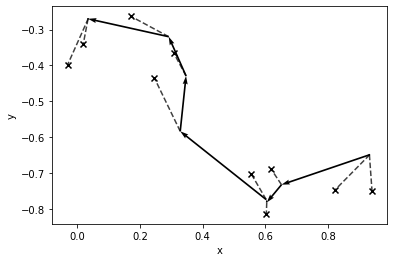

In [ ]:
n = 1
x_out_train,y_out_train = model.call(x_train[n])[0,:,0], model.call(x_train[n])[0,:,1]
initial = 25-1
final = 36-1
x = x_out_train.numpy()[initial+1:final]
y = y_out_train.numpy()[initial+1:final]
x_t = y_train[n][0,:,0]
y_t = y_train[n][0,:,1]
x_t = x_t[initial:final-1]
y_t = y_t[initial:final-1]
for i in range(len(x)):
  plt.plot(np.array([x_t[i],x[i]]), np.array([y_t[i],y[i]]), linestyle='--', color = 'black', alpha = 0.75)
  plt.scatter(x[i], y[i], color = 'black', marker = 'x')
plt.quiver(x_t[:-1], y_t[:-1], x_t[1:]-x_t[:-1], y_t[1:]-y_t[:-1], scale_units='xy', angles='xy', scale=1,
           color = 'black', width = 0.005, alpha = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('train_route_50_jag0',dpi = 300)
plt.show()

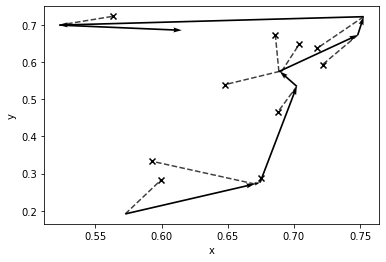

In [ ]:
n = 4
x_out_test,y_out_test = model.call(x_test[n])[0,:,0], model.call(x_test[n])[0,:,1]
initial = 25-1
final = 36-1
x = x_out_test.numpy()[initial+1:final]
y = y_out_test.numpy()[initial+1:final]
x_t = y_test[n][0,:,0]
y_t = y_test[n][0,:,1]
x_t = x_t[initial:final]
y_t = y_t[initial:final]
for i in range(len(x)):
  plt.plot(np.array([x_t[i],x[i]]), np.array([y_t[i],y[i]]), linestyle='--', color = 'black', alpha = 0.75)
  plt.scatter(x[i], y[i], color = 'black', marker = 'x')
plt.quiver(x_t[:-1], y_t[:-1], x_t[1:]-x_t[:-1], y_t[1:]-y_t[:-1], scale_units='xy', angles='xy', scale=1,
           color = 'black', width = 0.005, alpha = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('test_route_jag0',dpi = 300)
plt.show()

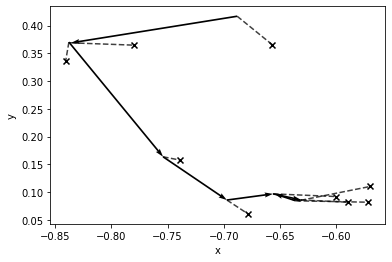

In [ ]:
n = 0
x_out_test_out,y_out_test_out = model.call(x_test_out_jags[n])[0,:,0], model.call(x_test_out_jags[n])[0,:,1]
initial = 20
final = 30
x = x_out_test_out.numpy()[initial+1:final]
y = y_out_test_out.numpy()[initial+1:final]
x_t = y_test_out_jags[n][0,:,0]
y_t = y_test_out_jags[n][0,:,1]
x_t = x_t[initial:final]
y_t = y_t[initial:final]
for i in range(len(x)):
  plt.plot(np.array([x_t[i],x[i]]), np.array([y_t[i],y[i]]), linestyle='--', color = 'black', alpha = 0.75)
  plt.scatter(x[i], y[i], color = 'black', marker = 'x')
plt.quiver(x_t[:-1], y_t[:-1], x_t[1:]-x_t[:-1], y_t[1:]-y_t[:-1], scale_units='xy', angles='xy', scale=1,
           color = 'black', width = 0.005, alpha = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('train_route_jag_out',dpi = 300)
plt.show()